In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("talk")

In [2]:
tickers = ["AAPL", "MSFT", "GOOG", "TSLA", "NFLX"]

data = yf.download(
    tickers=tickers,
    start="2022-01-01",
    end="2025-01-01",
    group_by="ticker",
    auto_adjust=True
)

[*********************100%***********************]  5 of 5 completed


In [3]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [4]:
processed_data = {}

for ticker in tickers:
    df = data[ticker].copy()

    df["returns"] = df["Close"].pct_change()
    df["ma_20"] = df["Close"].rolling(20).mean()
    df["ma_50"] = df["Close"].rolling(50).mean()
    df["rsi"] = compute_rsi(df["Close"])
    
    df.dropna(inplace=True)
    processed_data[ticker] = df

In [5]:
def detect_anomalies(df, threshold=3):
    df["price_zscore"] = zscore(df["Close"])
    df["volume_zscore"] = zscore(df["Volume"])
    
    df["price_anomaly"] = np.abs(df["price_zscore"]) > threshold
    df["volume_anomaly"] = np.abs(df["volume_zscore"]) > threshold
    
    return df

In [6]:
for ticker in tickers:
    processed_data[ticker] = detect_anomalies(processed_data[ticker])

In [7]:
import os
import matplotlib.pyplot as plt

os.makedirs("charts", exist_ok=True)

def plot_price_anomalies(ticker, df):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df["Close"], label="Close Price")
    
    anomalies = df[df["price_anomaly"]]
    plt.scatter(
        anomalies.index,
        anomalies["Close"],
        color="red",
        label="Price Anomaly",
        s=60
    )
    
    plt.title(f"{ticker} Price Anomaly Detection")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()

    plt.savefig(
        f"charts/{ticker}_price_anomalies.png",
        dpi=300,
        bbox_inches="tight"
    )

    plt.show()
    plt.close()

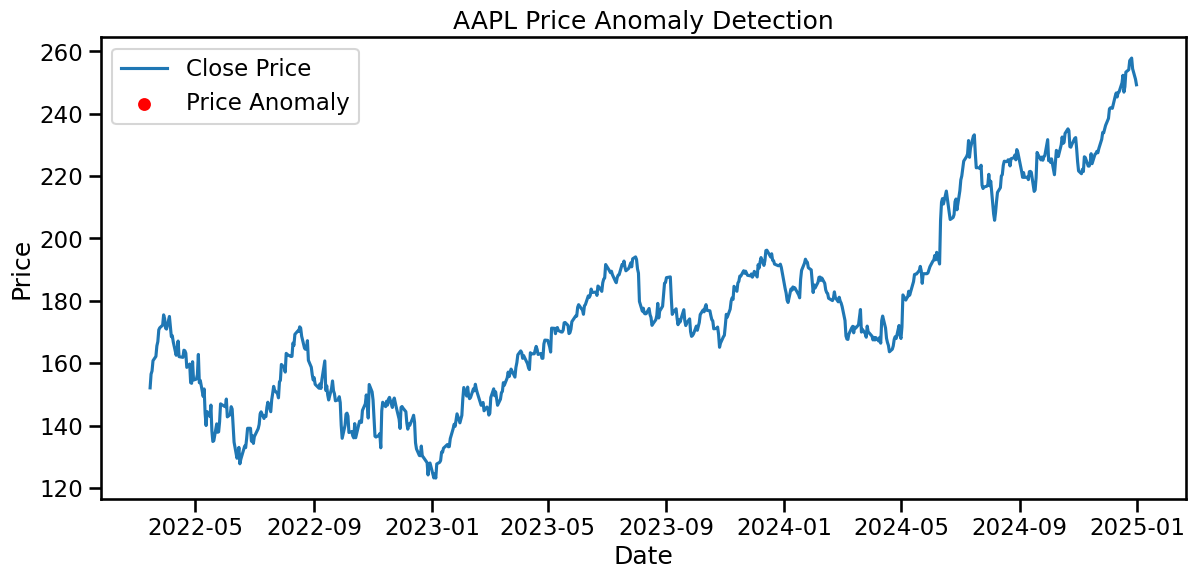

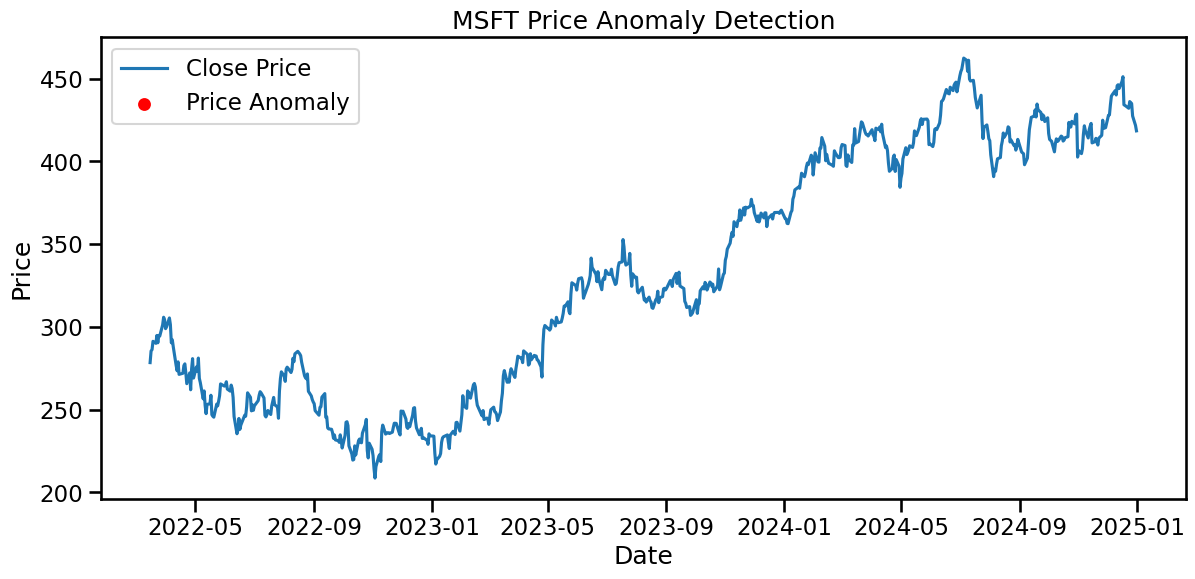

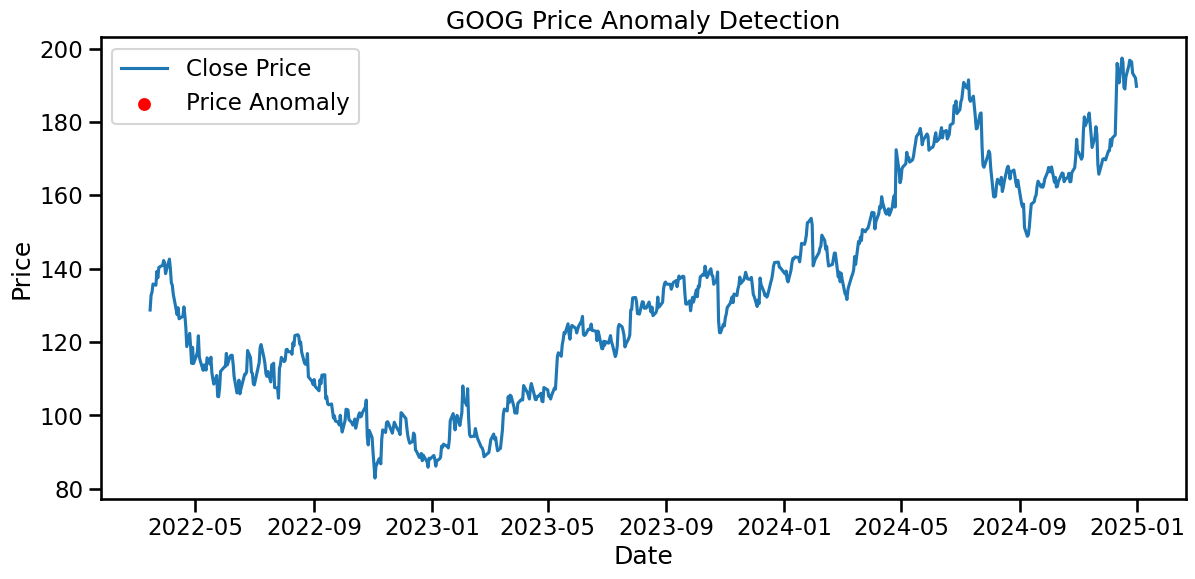

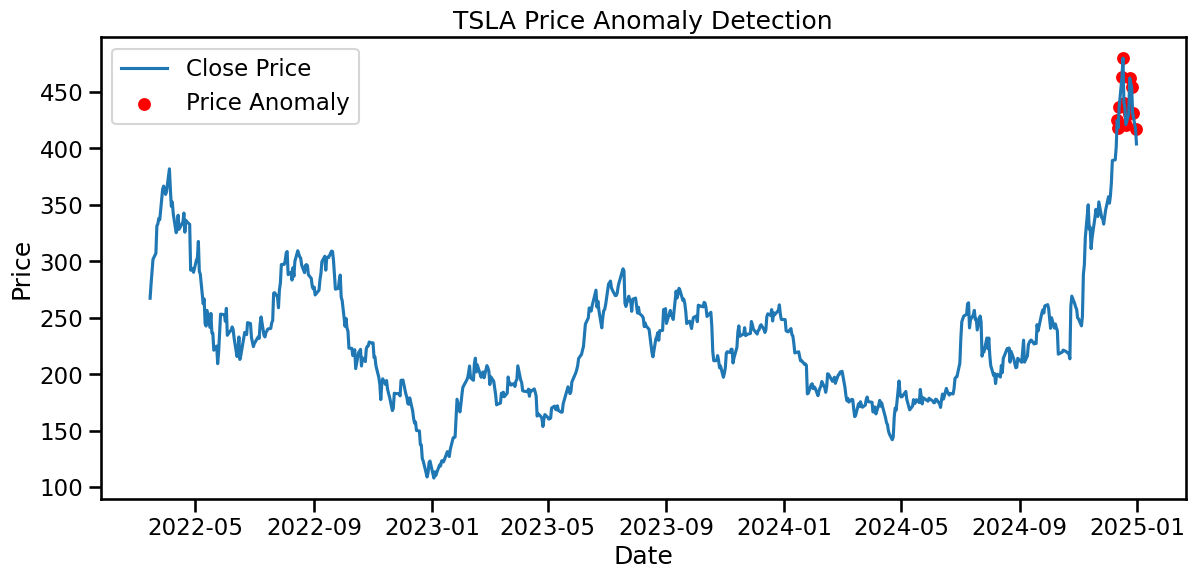

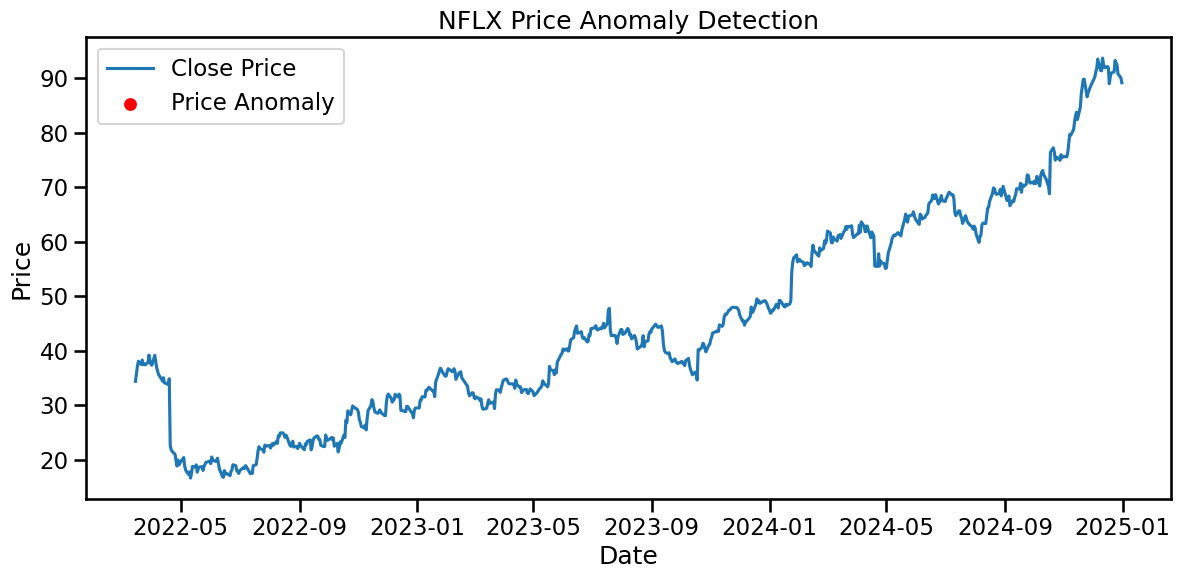

In [8]:
for ticker in tickers:
    plot_price_anomalies(ticker, processed_data[ticker])

In [9]:
import os
import matplotlib.pyplot as plt

os.makedirs("charts", exist_ok=True)

def plot_volume_anomalies(ticker, df):
    plt.figure(figsize=(14,4))
    plt.plot(df.index, df["Volume"], label="Volume")
    
    anomalies = df[df["volume_anomaly"]]
    plt.scatter(
        anomalies.index,
        anomalies["Volume"],
        color="orange",
        label="Volume Anomaly",
        s=60
    )
    
    plt.title(f"{ticker} Volume Anomalies")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.legend()

    plt.savefig(
        f"charts/{ticker}_volume_anomalies.png",
        dpi=300,
        bbox_inches="tight"
    )

    plt.show()
    plt.close()

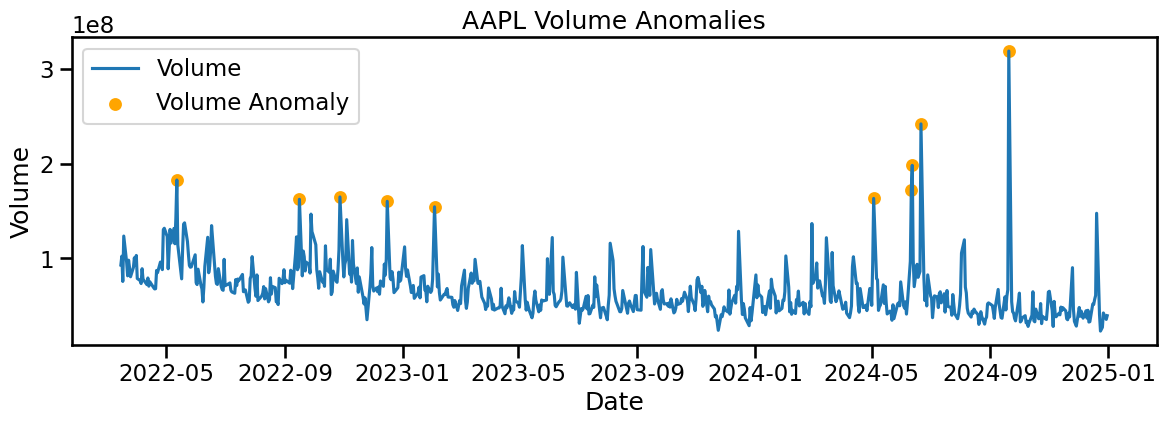

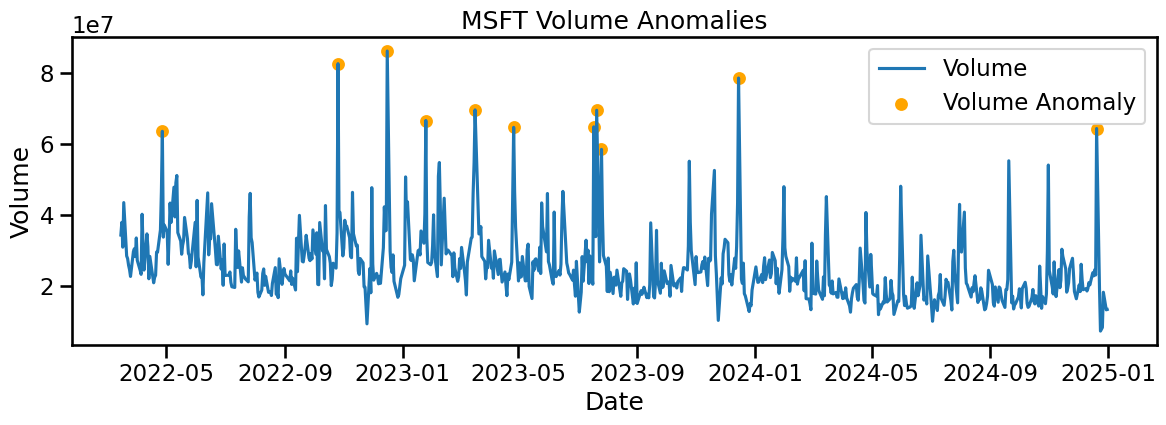

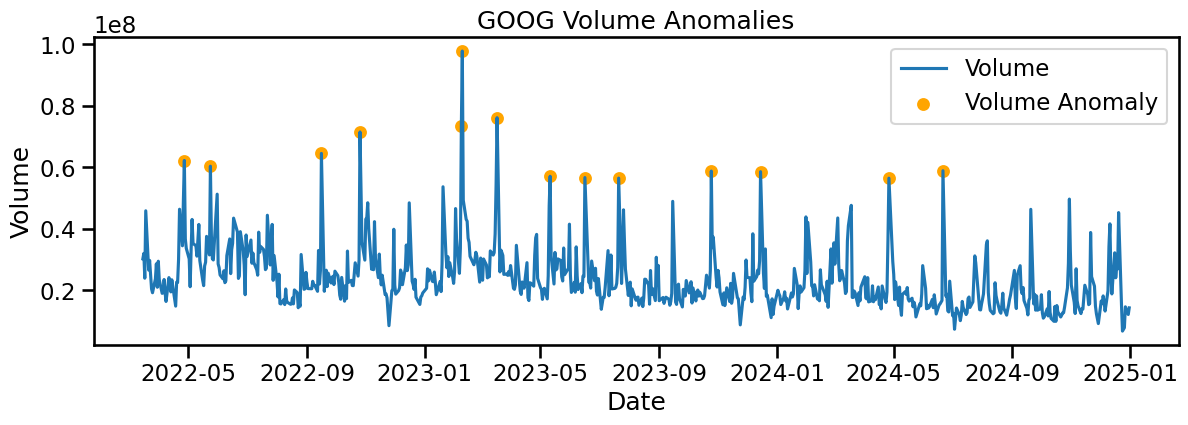

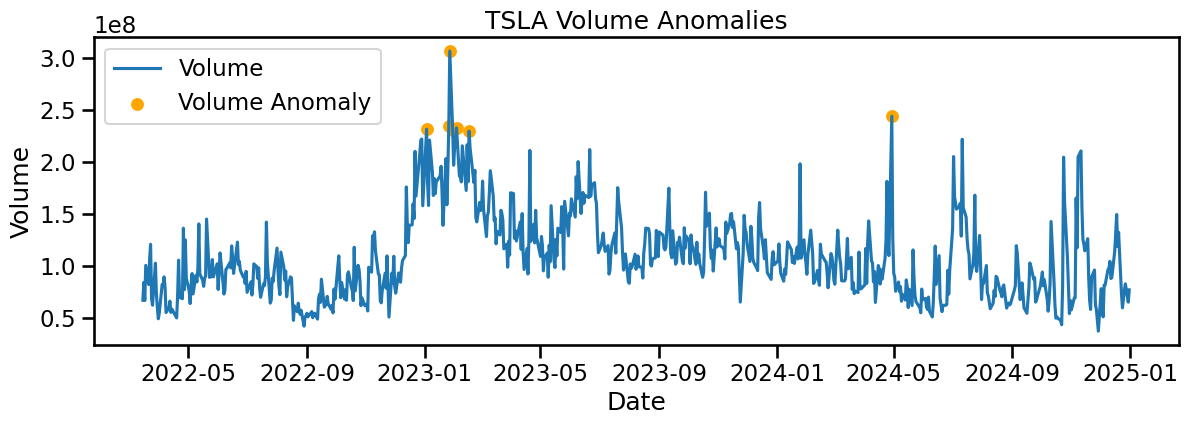

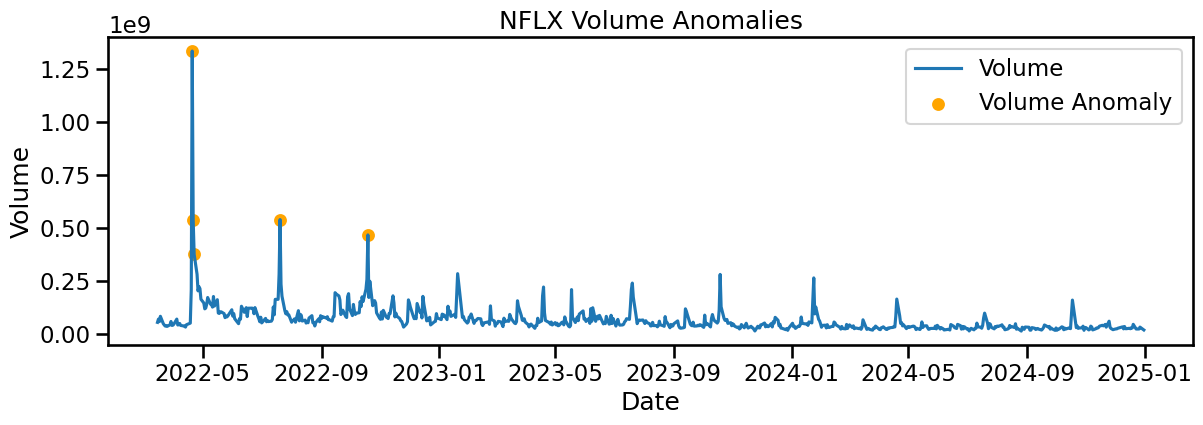

In [10]:
for ticker in tickers:
    plot_volume_anomalies(ticker, processed_data[ticker])

In [11]:
anomaly_matrix = pd.DataFrame()

for ticker in tickers:
    anomaly_matrix[ticker] = processed_data[ticker]["price_anomaly"].astype(int)

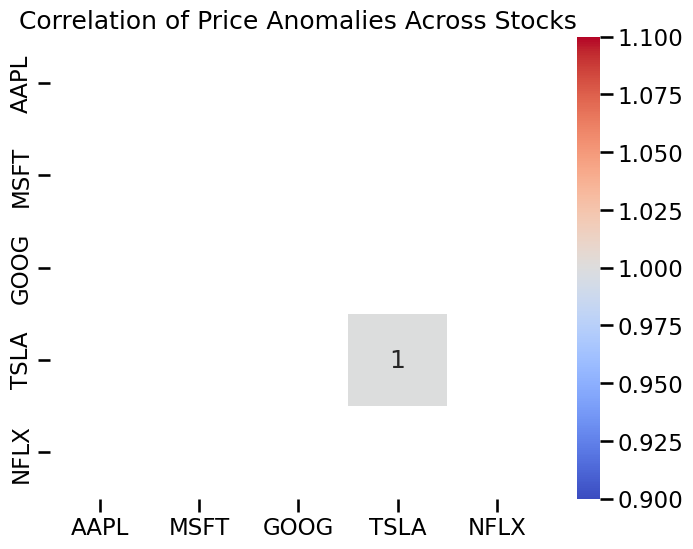

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(anomaly_matrix.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Price Anomalies Across Stocks")
plt.savefig(f"charts/Correlation_of_price_anomalies.png")
plt.show()

In [13]:
risk_scores = []

for ticker in tickers:
    df = processed_data[ticker]
    
    anomaly_count = df["price_anomaly"].sum()
    avg_magnitude = df.loc[df["price_anomaly"], "price_zscore"].abs().mean()
    
    risk_score = anomaly_count * avg_magnitude
    
    risk_scores.append({
        "Ticker": ticker,
        "Anomaly Count": anomaly_count,
        "Avg Magnitude": avg_magnitude,
        "Risk Score": risk_score
    })

In [14]:
risk_df = pd.DataFrame(risk_scores).sort_values("Risk Score", ascending=False)
risk_df

,Ticker,Anomaly Count,Avg Magnitude,Risk Score
3,TSLA,13,3.482599,45.273792
0,AAPL,0,NaN,NaN
1,MSFT,0,NaN,NaN
2,GOOG,0,NaN,NaN
4,NFLX,0,NaN,NaN


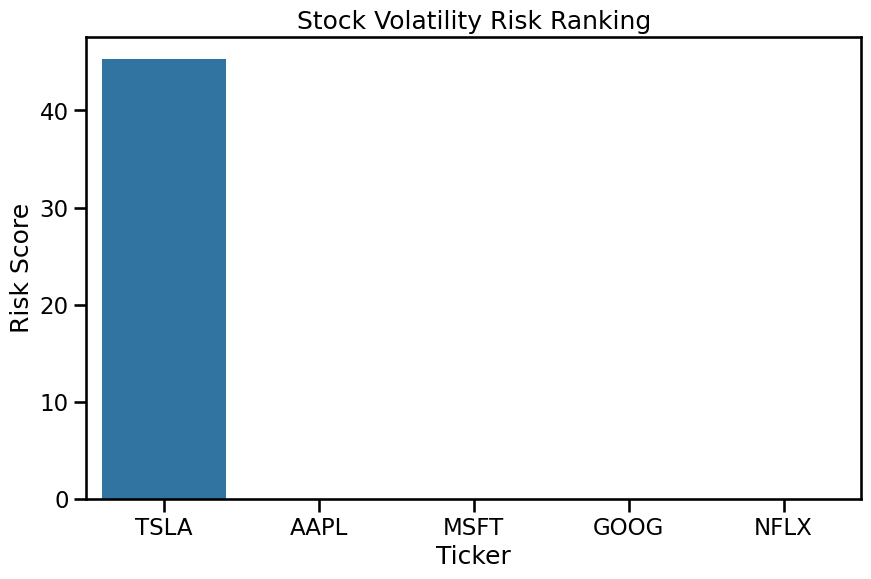

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(data=risk_df, x="Ticker", y="Risk Score")
plt.title("Stock Volatility Risk Ranking")
plt.show()

In [16]:
print("Most volatile stock based on anomaly risk:")
print(risk_df.iloc[0])

Most volatile stock based on anomaly risk:
Ticker                TSLA
Anomaly Count           13
Avg Magnitude     3.482599
Risk Score       45.273792
Name: 3, dtype: object
